In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading and preparing data...")
df = pd.read_excel('../data/processed/exploratory_analysis_final.xlsx', sheet_name='Sheet1')


Loading and preparing data...


In [15]:
# Display basic statistics
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['decision_grouped'].value_counts()}")

# --- Enhanced Feature Engineering ---
print("\nPerforming feature engineering...")

# Handle missing values in key columns first to enable calculations
for col in ['undergrad_gpa', 'gre_quantitative_reasoning', 'gre_verbal_reasoning', 
            'analytical_writing', 'acceptance_rate', 'qs_rank_score']:
    if col in df.columns:
        median = df[col].median()
        df[col] = df[col].fillna(median)


Dataset shape: (100621, 21)
Class distribution:
decision_grouped
0    37245
1    35986
2    27390
Name: count, dtype: int64

Performing feature engineering...


In [16]:

# Basic features from original model
if 'gre_avg' not in df.columns:
    df['gre_avg'] = (df['gre_quantitative_reasoning'] + df['gre_verbal_reasoning']) / 2
    
if 'gpa_percentile' not in df.columns:
    df['gpa_percentile'] = df['undergrad_gpa'].rank(pct=True)
    
if 'gpa_x_acceptancerate' not in df.columns:
    df['gpa_x_acceptancerate'] = df['undergrad_gpa'] * df['acceptance_rate']

# Existing interaction features
df['gpa_gre_interaction'] = df['undergrad_gpa'] * df['gre_avg']
df['gpa_acceptance_interaction'] = df['undergrad_gpa'] * df['acceptance_rate']

# Composite profile strength
df['profile_strength'] = df['gre_avg'] * df['gpa_percentile'] * (1 - df['acceptance_rate'] + 0.001)

# Rank bucketing
def rank_bucket(score):
    if pd.isna(score):
        return 'Unknown'
    elif score <= -10:
        return 'Top 10'
    elif score <= -50:
        return 'Top 50'
    elif score <= -100:
        return 'Top 100'
    else:
        return 'Other'

df['qs_rank_bucket'] = df['qs_rank_score'].apply(rank_bucket)


In [17]:
# New features for the improved model
# Square and cube terms for important numeric features
df['gre_avg_squared'] = df['gre_avg'] ** 2
df['undergrad_gpa_squared'] = df['undergrad_gpa'] ** 2
df['gre_avg_cubed'] = df['gre_avg'] ** 3
df['undergrad_gpa_cubed'] = df['undergrad_gpa'] ** 3

# Ratio features
df['gre_to_acceptance_ratio'] = df['gre_avg'] / (df['acceptance_rate'] + 0.001)
df['gpa_to_acceptance_ratio'] = df['undergrad_gpa'] / (df['acceptance_rate'] + 0.001)

# More interaction terms
df['gre_verbal_quant_product'] = df['gre_verbal_reasoning'] * df['gre_quantitative_reasoning']
df['gre_analytical_product'] = df['gre_avg'] * df['analytical_writing']
df['gpa_analytical_product'] = df['undergrad_gpa'] * df['analytical_writing']

# Transform acceptance rate (since lower is better)
df['inverse_acceptance'] = 1 / (df['acceptance_rate'] + 0.001)
df['log_acceptance'] = np.log1p(df['acceptance_rate'])

# Add percentile ranks for key metrics
df['gre_quant_percentile'] = df['gre_quantitative_reasoning'].rank(pct=True)
df['gre_verbal_percentile'] = df['gre_verbal_reasoning'].rank(pct=True)
df['analytical_percentile'] = df['analytical_writing'].rank(pct=True)


In [18]:
# Combine multiple factors into comprehensive scores
df['academic_score'] = (df['gpa_percentile'] + df['gre_quant_percentile'] + 
                        df['gre_verbal_percentile'] + df['analytical_percentile']) / 4
df['weighted_score'] = (df['gpa_percentile'] * 0.4 + 
                       df['gre_quant_percentile'] * 0.3 + 
                       df['gre_verbal_percentile'] * 0.2 + 
                       df['analytical_percentile'] * 0.1)

# Squared differences (distance from perfect scores)
max_gpa = df['undergrad_gpa'].max()
df['gpa_distance'] = (max_gpa - df['undergrad_gpa']) ** 2

max_gre = df['gre_avg'].max()
df['gre_distance'] = (max_gre - df['gre_avg']) ** 2

# Combined feature using z-scores
for col in ['undergrad_gpa', 'gre_avg', 'analytical_writing']:
    df[f'{col}_zscore'] = (df[col] - df[col].mean()) / df[col].std()

df['combined_zscore'] = (df['undergrad_gpa_zscore'] + 
                         df['gre_avg_zscore'] + 
                         df['analytical_writing_zscore'])


In [19]:
# Update feature list with all new features
features = [
    # Original features
    'undergrad_gpa', 'gre_quantitative_reasoning', 'gre_verbal_reasoning',
    'analytical_writing', 'acceptance_rate', 'qs_rank_score', 'qs_tier',
    'gpa_percentile', 'gre_avg', 'gpa_x_acceptancerate',
    'gpa_gre_interaction', 'gpa_acceptance_interaction',
    'profile_strength', 'qs_rank_bucket',
    # New features
    'gre_avg_squared', 'undergrad_gpa_squared', 'gre_avg_cubed', 'undergrad_gpa_cubed',
    'gre_to_acceptance_ratio', 'gpa_to_acceptance_ratio',
    'gre_verbal_quant_product', 'gre_analytical_product', 'gpa_analytical_product',
    'inverse_acceptance', 'log_acceptance',
    'gre_quant_percentile', 'gre_verbal_percentile', 'analytical_percentile',
    'academic_score', 'weighted_score', 'gpa_distance', 'gre_distance',
    'undergrad_gpa_zscore', 'gre_avg_zscore', 'analytical_writing_zscore', 'combined_zscore'
]


In [20]:
# Remove any features that don't exist in the dataframe
features = [f for f in features if f in df.columns]
print(f"Total features after engineering: {len(features)}")

# Create binary target: 1 if admitted, 0 otherwise
df['binary_decision'] = df['decision_grouped'].apply(lambda x: 1 if x == 1 else 0)

# Check for class imbalance
class_counts = df['binary_decision'].value_counts()
print(f"Class distribution (binary): {class_counts}")
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"Class imbalance ratio (rejected:admitted): {imbalance_ratio:.2f}:1")

X = df[features]
y = df['binary_decision']


Total features after engineering: 36
Class distribution (binary): binary_decision
0    64635
1    35986
Name: count, dtype: int64
Class imbalance ratio (rejected:admitted): 1.80:1


In [21]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# --- Preprocessing pipelines ---
print("\nConfiguring preprocessing pipelines...")

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


Numeric features: 35
Categorical features: 1

Configuring preprocessing pipelines...


In [22]:
# --- Feature importance analysis ---
print("\nAnalyzing feature importance...")

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train a basic model for feature importance
base_model = XGBClassifier(
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss',
    scale_pos_weight=imbalance_ratio  # Address class imbalance
)
base_model.fit(X_train_preprocessed, y_train)



Analyzing feature importance...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [23]:
# Get feature importances
if hasattr(preprocessor, 'get_feature_names_out'):
    all_feature_names = preprocessor.get_feature_names_out()
else:
    # Fallback for older sklearn versions
    numeric_features_out = numeric_features
    categorical_features_out = []
    for name, _, cols in preprocessor.transformers_:
        if name == 'cat':
            for col in cols:
                categorical_features_out.extend([f"{col}_{cat}" for cat in df[col].dropna().unique()])
    all_feature_names = numeric_features_out + categorical_features_out

# Only use the number of features that actually exist
n_features = min(len(all_feature_names), len(base_model.feature_importances_))
feature_importances = pd.DataFrame({
    'Feature': all_feature_names[:n_features],
    'Importance': base_model.feature_importances_[:n_features]
}).sort_values(by='Importance', ascending=False)

# Select top features
top_n = min(20, len(feature_importances))  # Top 20 or all if fewer
top_features = feature_importances.head(top_n)
print(f"\nTop {top_n} features by importance:")
print(top_features)



Top 20 features by importance:
                            Feature  Importance
4              num__acceptance_rate    0.168804
23              num__log_acceptance    0.143644
22          num__inverse_acceptance    0.041455
9         num__gpa_x_acceptancerate    0.039823
6                      num__qs_tier    0.037682
5                num__qs_rank_score    0.034513
1   num__gre_quantitative_reasoning    0.032171
28              num__weighted_score    0.029196
19    num__gre_verbal_quant_product    0.028887
13             num__gre_avg_squared    0.028541
11  num__gpa_acceptance_interaction    0.028420
16         num__undergrad_gpa_cubed    0.028098
27              num__academic_score    0.026775
14       num__undergrad_gpa_squared    0.026645
34             num__combined_zscore    0.026553
12            num__profile_strength    0.026461
17     num__gre_to_acceptance_ratio    0.026212
8                      num__gre_avg    0.026116
21      num__gpa_analytical_product    0.025889
18     n

In [24]:
# Feature selection using the model
print("\nPerforming feature selection...")
selector = SelectFromModel(base_model, threshold='median', prefit=True)
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)
print(f"Selected {X_train_selected.shape[1]} out of {X_train_preprocessed.shape[1]} features")

# --- Model Training with SMOTE for class imbalance ---
print("\nTraining models with SMOTE to handle class imbalance...")

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)
print(f"Training data shape after SMOTE: {X_train_smote.shape}")
print(f"Class distribution after SMOTE: {pd.Series(y_train_smote).value_counts()}")

# --- Define multiple models ---
print("\nConfiguring models...")



Performing feature selection...
Selected 19 out of 37 features

Training models with SMOTE to handle class imbalance...
Training data shape after SMOTE: (103414, 37)
Class distribution after SMOTE: binary_decision
0    51707
1    51707
Name: count, dtype: int64

Configuring models...


In [25]:
# XGBoost with custom parameters
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Random Forest
rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Logistic Regression
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    n_jobs=-1
)


In [26]:
# --- Grid search for XGBoost ---
print("\nPerforming grid search for XGBoost hyperparameters...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1]
}

grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=5,
    scoring='f1',  # Focus on balanced performance
    verbose=1, 
    n_jobs=-1
)



Performing grid search for XGBoost hyperparameters...


In [27]:
grid_search.fit(X_train_smote, y_train_smote)
print(f"Best parameters: {grid_search.best_params_}")
best_xgb = grid_search.best_estimator_

# --- Train Random Forest and Logistic Regression ---
print("\nTraining Random Forest and Logistic Regression models...")
rf_model.fit(X_train_smote, y_train_smote)
lr_model.fit(X_train_smote, y_train_smote)

# --- Create Voting Classifier (Ensemble) ---
print("\nCreating ensemble model...")
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('rf', rf_model),
        ('lr', lr_model)
    ],
    voting='soft'  # Use probability predictions
)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:59:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

Training Random Forest and Logistic Regression models...

Creating ensemble model...


In [28]:
voting_clf.fit(X_train_smote, y_train_smote)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_r...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(n_jobs=-1,
                                                     random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000, n_jobs=-1,
                                                 random_state=42))],
                 voting='soft')

In [29]:

# --- Model Evaluation ---
print("\nEvaluating models on test set...")

# Function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # For ROC AUC, we need probability predictions
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None
    
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Rejected', 'Admitted'],
                yticklabels=['Rejected', 'Admitted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }



Evaluating models on test set...



XGBoost (Best) Performance:
Accuracy: 0.5998
F1 Score: 0.4977
ROC AUC: 0.6262

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.62      0.67     12928
           1       0.45      0.55      0.50      7197

    accuracy                           0.60     20125
   macro avg       0.58      0.59      0.58     20125
weighted avg       0.62      0.60      0.61     20125



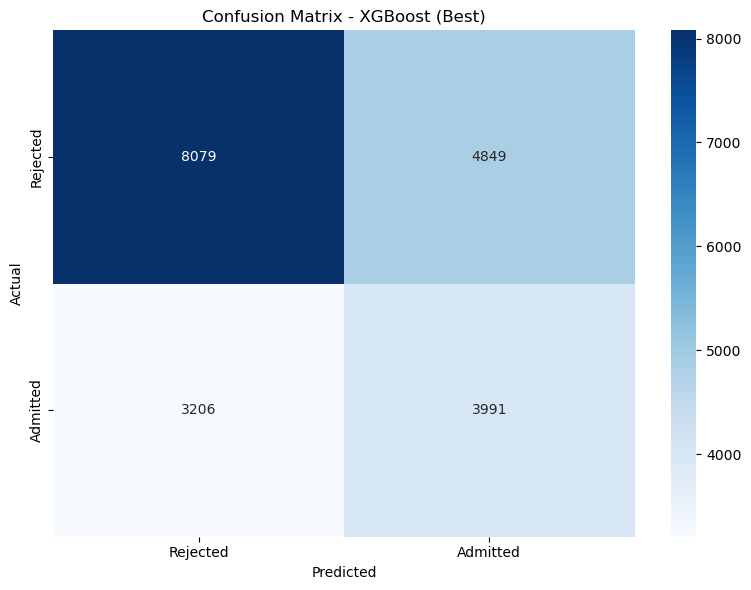


Random Forest Performance:
Accuracy: 0.6253
F1 Score: 0.4101
ROC AUC: 0.6024

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73     12928
           1       0.47      0.36      0.41      7197

    accuracy                           0.63     20125
   macro avg       0.58      0.57      0.57     20125
weighted avg       0.61      0.63      0.61     20125



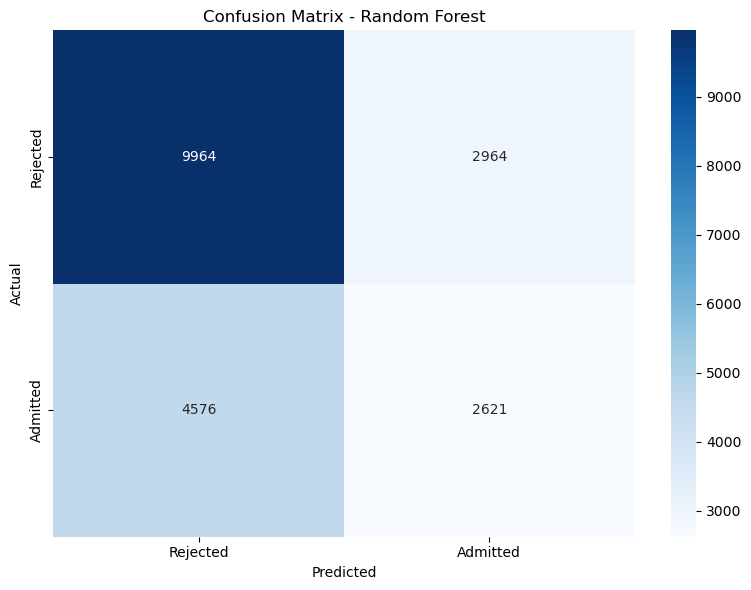


Logistic Regression Performance:
Accuracy: 0.5827
F1 Score: 0.5015
ROC AUC: 0.6165

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.58      0.64     12928
           1       0.44      0.59      0.50      7197

    accuracy                           0.58     20125
   macro avg       0.58      0.58      0.57     20125
weighted avg       0.62      0.58      0.59     20125



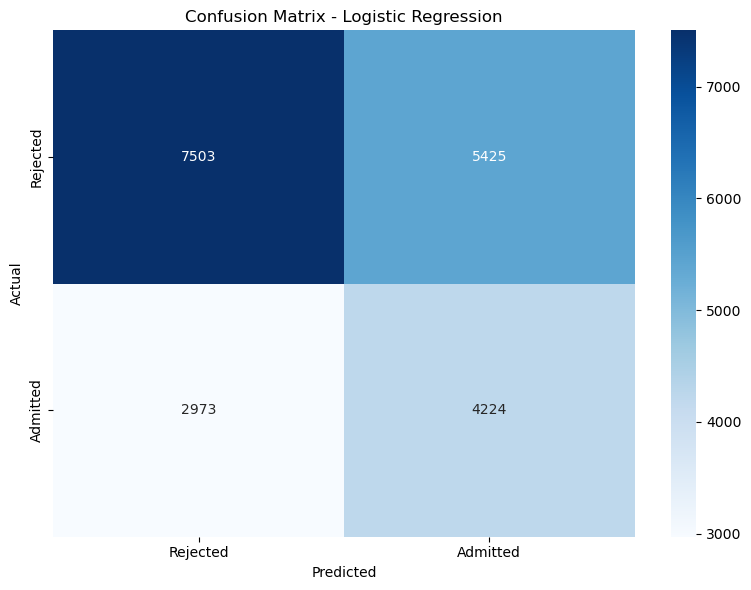


Ensemble (Voting) Performance:
Accuracy: 0.6225
F1 Score: 0.4628
ROC AUC: 0.6264

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71     12928
           1       0.47      0.45      0.46      7197

    accuracy                           0.62     20125
   macro avg       0.59      0.59      0.59     20125
weighted avg       0.62      0.62      0.62     20125



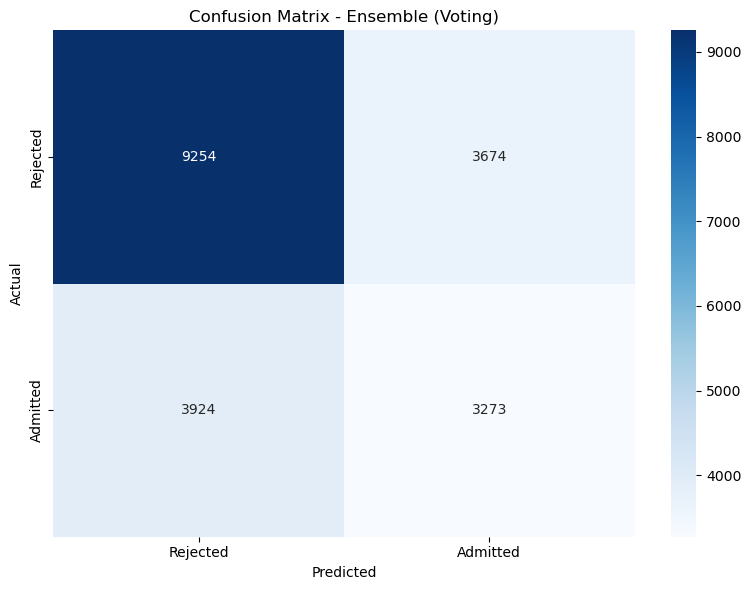

In [30]:
# Evaluate each model
xgb_results = evaluate_model(best_xgb, X_test_preprocessed, y_test, "XGBoost (Best)")
rf_results = evaluate_model(rf_model, X_test_preprocessed, y_test, "Random Forest")
lr_results = evaluate_model(lr_model, X_test_preprocessed, y_test, "Logistic Regression")
ensemble_results = evaluate_model(voting_clf, X_test_preprocessed, y_test, "Ensemble (Voting)")

In [31]:
# Compare models
models = ["XGBoost", "Random Forest", "Logistic Regression", "Ensemble"]
metrics = ["accuracy", "f1", "roc_auc"]
results = [xgb_results, rf_results, lr_results, ensemble_results]

comparison = {}
for metric in metrics:
    if metric == 'roc_auc' and None in [r.get(metric) for r in results]:
        continue
    comparison[metric] = [r.get(metric) for r in results]

results_df = pd.DataFrame(comparison, index=models)
print("\nModel Comparison:")
print(results_df)



Model Comparison:
                     accuracy        f1   roc_auc
XGBoost              0.599752  0.497724  0.626160
Random Forest        0.625342  0.410108  0.602353
Logistic Regression  0.582708  0.501484  0.616499
Ensemble             0.622460  0.462811  0.626358


<Figure size 1000x600 with 0 Axes>

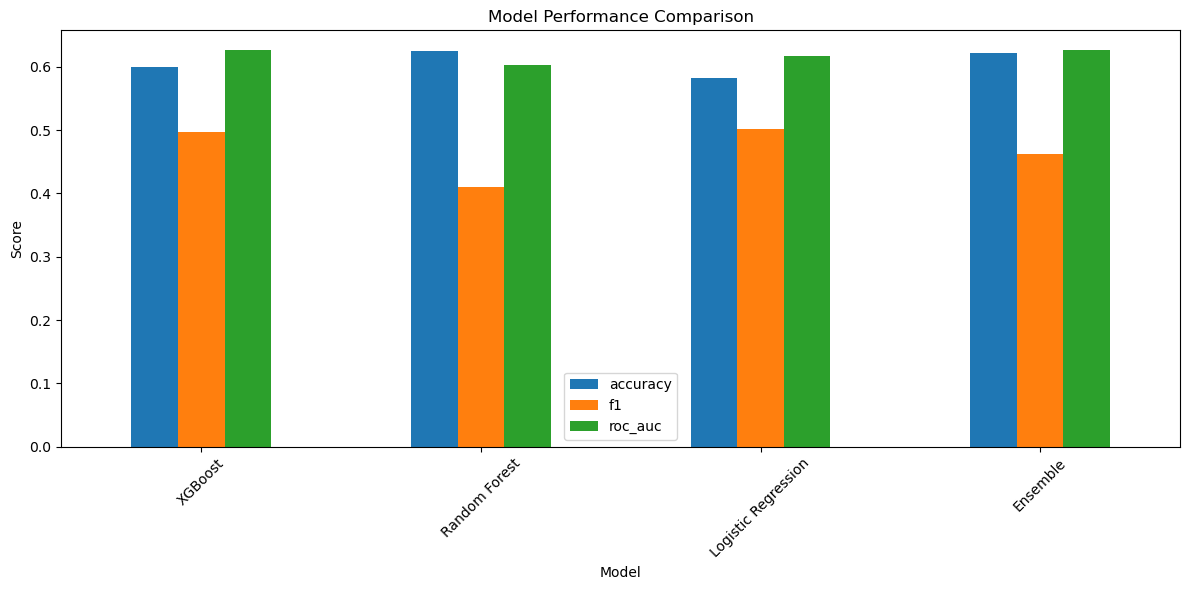

In [32]:
# Plot comparison
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Visualizing feature importance...


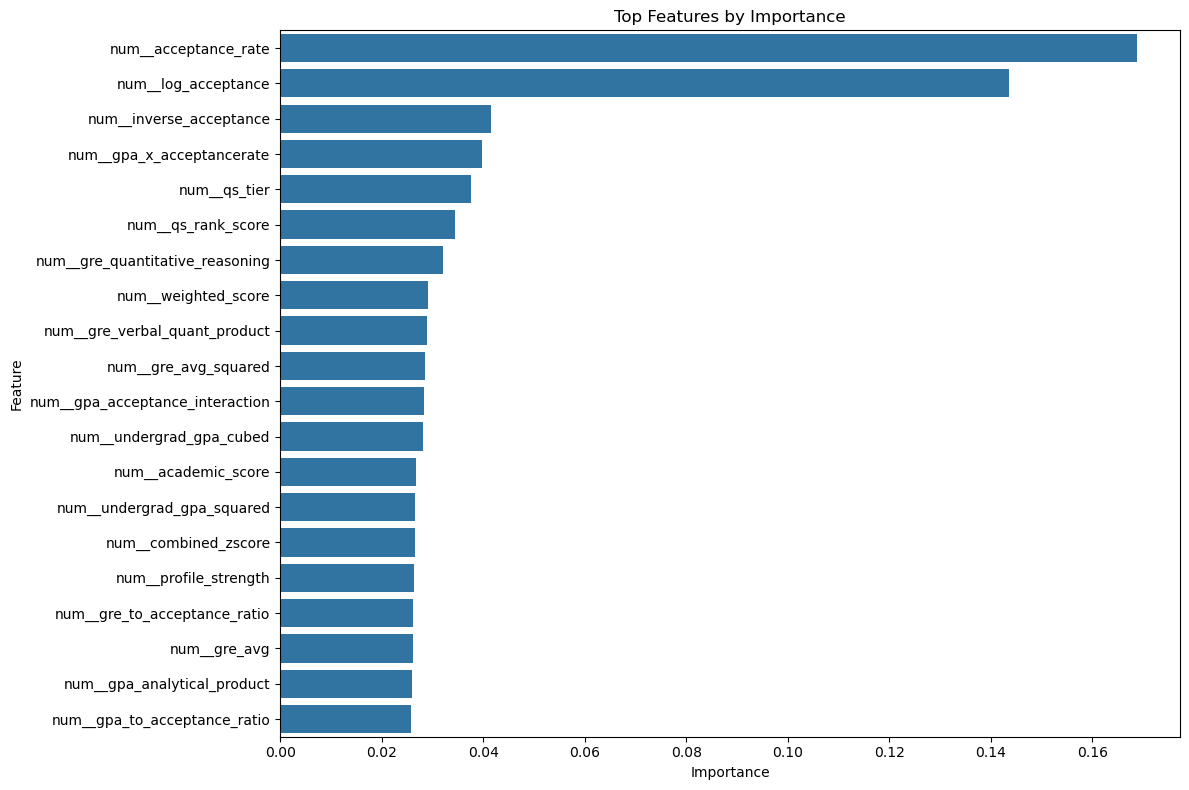

In [33]:
# --- Feature Importance Visualization ---
print("\nVisualizing feature importance...")
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top Features by Importance')
plt.tight_layout()
plt.show()


In [34]:
# --- Save the best model ---
print("\nSaving the best model...")


Saving the best model...


In [35]:
# Identify best model based on F1 score
best_f1 = max(results, key=lambda x: x['f1'])
best_model_index = results.index(best_f1)
best_model = [best_xgb, rf_model, lr_model, voting_clf][best_model_index]
best_model_name = models[best_model_index]

print(f"The best model is {best_model_name} with F1 score: {best_f1['f1']:.4f}")

# Create a pipeline with preprocessing and the best model
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Save the pipeline
with open('best_grad_admission_model.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)

print("\nComplete! Best model pipeline saved as 'best_grad_admission_model.pkl'")


The best model is Logistic Regression with F1 score: 0.5015

Complete! Best model pipeline saved as 'best_grad_admission_model.pkl'


In [36]:
# Function for making predictions on new data
def predict_admission_chance(pipeline, new_data):
    """
    Predict admission probability for new student data.
    
    Parameters:
    -----------
    pipeline : Pipeline
        Trained model pipeline
    new_data : DataFrame
        New student data with required features
    
    Returns:
    --------
    DataFrame with original data and admission probability
    """
    # Make prediction
    if hasattr(pipeline, "predict_proba"):
        proba = pipeline.predict_proba(new_data)[:, 1]
        prediction = pipeline.predict(new_data)
    else:
        proba = None
        prediction = pipeline.predict(new_data)
    
    # Add predictions to the dataframe
    result = new_data.copy()
    result['admission_probability'] = proba if proba is not None else prediction
    result['predicted_decision'] = prediction
    result['predicted_result'] = result['predicted_decision'].map({1: 'Admitted', 0: 'Rejected'})
    
    return result


In [37]:
print("\nExample usage for prediction function:")
print("new_student = pd.DataFrame({'undergrad_gpa': [3.8], 'gre_quantitative_reasoning': [165], ...})")
print("result = predict_admission_chance(best_pipeline, new_student)")
print("print(f\"Admission probability: {result['admission_probability'][0]:.2%}\")")


Example usage for prediction function:
new_student = pd.DataFrame({'undergrad_gpa': [3.8], 'gre_quantitative_reasoning': [165], ...})
result = predict_admission_chance(best_pipeline, new_student)
print(f"Admission probability: {result['admission_probability'][0]:.2%}")
